<a href="https://colab.research.google.com/github/justinsydnor/GB894/blob/main/DemoPermutationImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation Demo of Feature Importance vs. Permutation Importance

This demo illustrates the difference between two common methods for measuring feature importance in tree-based models:

###MDI Importance (Mean Decrease in Impurity)
This method calculates importance based on how much each feature reduces Gini impurity across all splits in a random forest. It is computed during training and can be biased toward features with many levels or high cardinality.

###Permutation Importance
This is a model-agnostic, post-hoc method that measures how much the model's performance drops when a feature is randomly shuffled. It reflects how necessary each feature is for accurate predictions and handles correlated features better.

## How the Demo Simulation Works

Synthetic classification data is generated with:



*   3 informative features (X0, X1, X2)
*   2 redundant (correlated) features (X3, X4)
*   5 noisy features (X5-X9)


Then, a RandomForestClassifier is trained on the data.

Two types of feature importance are computed:


*   rf.feature_importances_ (MDI)
*   permutation_importance() using accuracy as the scoring metric


The importances are plotted side-by-side to compare which features the model split on vs. which actually affect performance.

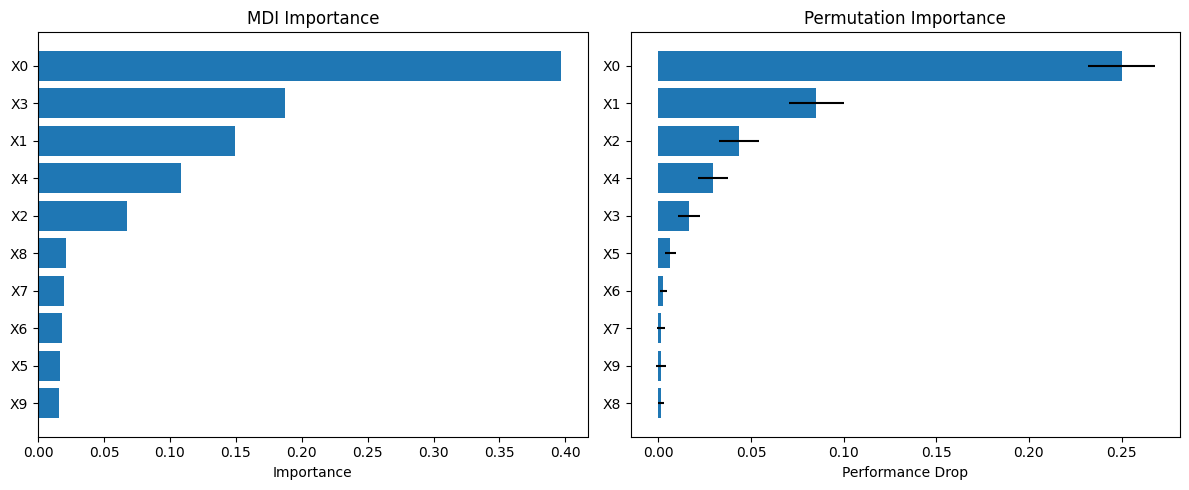

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Generate data
X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=2, random_state=42, shuffle=False)
feature_names = [f"X{i}" for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=feature_names)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train RF
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# MDI importance
mdi_importances = pd.DataFrame({
    'Feature': feature_names,
    'MDI Importance': rf.feature_importances_
}).sort_values('MDI Importance', ascending=False)

# Permutation importance
perm_result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_importances = pd.DataFrame({
    'Feature': feature_names,
    'Permutation Mean': perm_result.importances_mean,
    'Permutation Std': perm_result.importances_std
}).sort_values('Permutation Mean', ascending=False)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.barh(mdi_importances['Feature'], mdi_importances['MDI Importance'])
plt.gca().invert_yaxis()
plt.title('MDI Importance')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(perm_importances['Feature'], perm_importances['Permutation Mean'], xerr=perm_importances['Permutation Std'])
plt.gca().invert_yaxis()
plt.title('Permutation Importance')
plt.xlabel('Performance Drop')

plt.tight_layout()
plt.show()


So we see here that Permutation Importance picked up on the variables in order of their actual effects as simulated in the data. Feature Importance (MDI Importance) on the other hand wrongly ranked both X3 and  X4 (redundant features) as more important than X2 (an informative feature).

** Take away**: The big lesson here is that Permutation Importance is a much more reliable and powerful way of understanding what is mattering for the model predictions.